# Balancing weights

In [1]:
import numpy as np
import pyensmallen as pe
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

Low rank factor DGP

In [2]:
# Generate panel data based on a latent factor model
def generate_panel_data(N, T, K, sigma=0.1):
    F = np.random.randn(T, K)
    L = np.random.randn(N, K)
    epsilon = np.random.normal(0, sigma, (N, T))
    Y = np.dot(L, F.T) + epsilon
    return Y, L


def assign_treatment_probabilistic(L, n_treated=1, temperature=1.0):
    probabilities = expit(L[:, 0] / temperature)
    probabilities /= probabilities.sum()
    treated_units = np.random.choice(
        len(L), size=n_treated, replace=False, p=probabilities
    )

    return treated_units


## balancing weights


An interesting approach to synthetic control (style) weights might be to solve for the weights that minimize the difference between the treated unit and the synthetic control unit, with the proviso that the weights are have a certain structure. Common structures include
+ non-negativity
+ sum to one
+ sparsity

Classic synth chooses (1) and (2), and implicitly gets (3). If we relax (1) and (2), we can get a more flexible set of weights. We constrain the weights to be in a $\ell$-p ball, where $p$ is a parameter that we can tune.


In [3]:
def objective(w, X, y):
    return np.sum((np.dot(X, w) - y) ** 2)


def gradient(w, X, y):
    return 2 * np.dot(X.T, (np.dot(X, w) - y))


# Solve synthetic control problem using Frank-Wolfe
def synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=1.0):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    N_control = Y_control.shape[0]

    def f(w, grad):
        if grad.size > 0:
            grad[:] = gradient(w, Y_control.T, Y_treated)
        return objective(w, Y_control.T, Y_treated)

    # pnorm Frank-Wolfe solution
    optimizer = pe.FrankWolfe(p=p, max_iterations=10000, tolerance=1e-8)
    initial_w = np.ones(N_control) / N_control
    w_opt = optimizer.optimize(f, initial_w)
    return w_opt


def synthetic_control_linear(Y, treated_units, T_pre):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    coef = np.linalg.lstsq(Y_control.T, Y_treated, rcond=None)[0]
    return coef


Projection into simplex solution 

In [4]:

def project_onto_simplex(v, z=1.0):
    n = len(v)
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    rho = np.nonzero(u * np.arange(1, n + 1) > cssv)[0][-1]
    theta = cssv[rho] / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w

def synthetic_control_simplex(X, y, z=1.0):
    # Solve the least squares problem
    coef = np.linalg.lstsq(X.T, y, rcond=None)[0]
    # Project the coefficients onto the simplex
    w = project_onto_simplex(coef, z)
    return w

def synthetic_control_linear_simplex(Y, treated_units, T_pre, z=1.0):
    Y_treated = Y[treated_units, :T_pre].mean(axis=0)
    Y_control = Y[np.setdiff1d(range(Y.shape[0]), treated_units), :T_pre]
    # Use the simplex projection method
    coef = synthetic_control_simplex(Y_control, Y_treated, z)
    return coef

In [5]:

# Main experiment
N, T, K = 100, 50, 4
n_treated = 5
T_pre = T - 1

# Generate data
Y, L = generate_panel_data(N, T, K)
treated_units = assign_treatment_probabilistic(L, n_treated)
# Solve synthetic control problem
w_opt_1 = synthetic_control_frank_wolfe(Y, treated_units, T_pre)
w_opt_2 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=2.0)
w_opt_linear = synthetic_control_linear(Y, treated_units, T_pre)
w_simplex = synthetic_control_linear_simplex(Y, treated_units, T_pre)

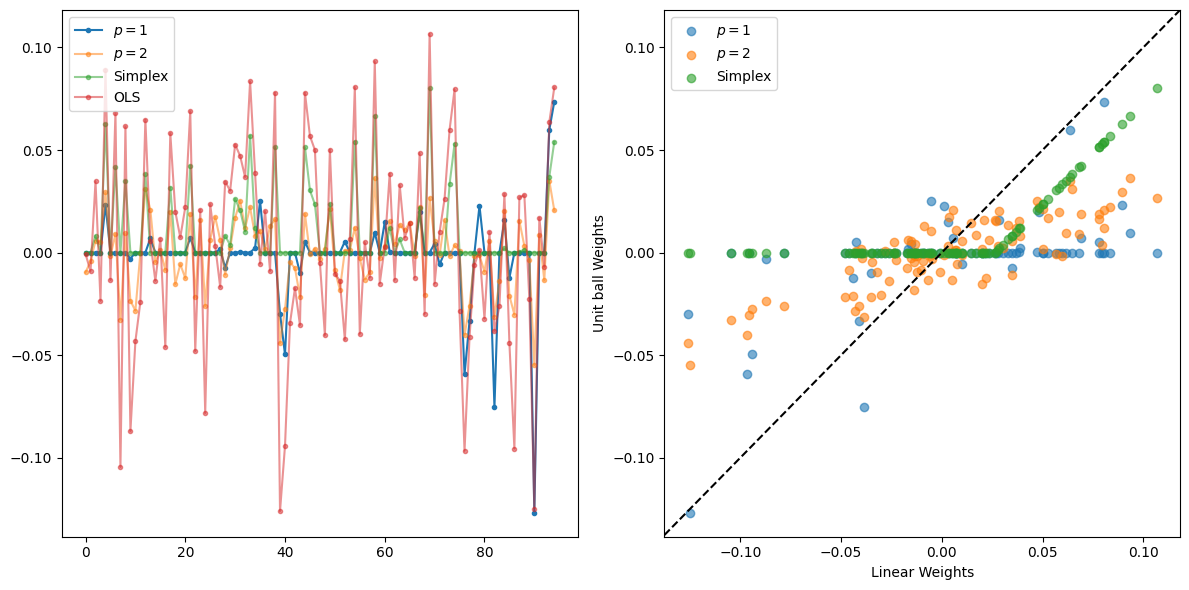

In [6]:
f, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(w_opt_1, label=r"$p=1$", marker=".")
ax[0].plot(w_opt_2, label=r"$p=2$", marker=".", alpha = 0.5)
ax[0].plot(w_simplex, label="Simplex", marker=".", alpha=0.5)
ax[0].plot(w_opt_linear, label="OLS", marker=".", alpha=0.5)
ax[0].legend()
ax[1].scatter(w_opt_linear, w_opt_1, alpha=0.6, label="$p=1$")
ax[1].scatter(w_opt_linear, w_opt_2, alpha=0.6, label="$p=2$")
ax[1].scatter(w_opt_linear, w_simplex, alpha=0.6, label="Simplex")
ax[1].axline([w_opt_linear.min(), w_opt_linear.min()], [w_opt_linear.max(), w_opt_linear.max()],
             color="black", linestyle="--")
ax[1].legend()
ax[1].set_xlabel("Linear Weights")
ax[1].set_ylabel("Unit ball Weights")
f.tight_layout()

In [7]:
from joblib import Parallel, delayed


def one_run():
    Y, L = generate_panel_data(N, T, K)
    treated_units = assign_treatment_probabilistic(L, n_treated)
    ctrl_id = np.setdiff1d(range(N), treated_units)
    w_opt_1 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=1.0)
    w_opt_2 = synthetic_control_frank_wolfe(Y, treated_units, T_pre, p=2.0)
    w_opt_linear = synthetic_control_linear(Y, treated_units, T_pre)
    bias_reg_1 = Y[treated_units, -1].mean() - np.dot(Y[ctrl_id, -1], w_opt_1)
    bias_reg_2 = Y[treated_units, -1].mean() - np.dot(Y[ctrl_id, -1], w_opt_2)
    bias_ols = Y[treated_units, -1].mean() - np.dot(Y[ctrl_id, -1], w_opt_linear)
    bias_simplex = Y[treated_units, -1].mean() - np.dot(Y[ctrl_id, -1], w_simplex)
    return bias_reg_1, bias_reg_2, bias_ols, bias_simplex


res = Parallel(n_jobs=-1)(delayed(one_run)() for _ in range(1000))
res = np.array(res)
biases_reg_1, biases_reg_2, biases_ols, biases_simplex = (
    res[:, 0],
    res[:, 1],
    res[:, 2],
    res[:, 3],
)

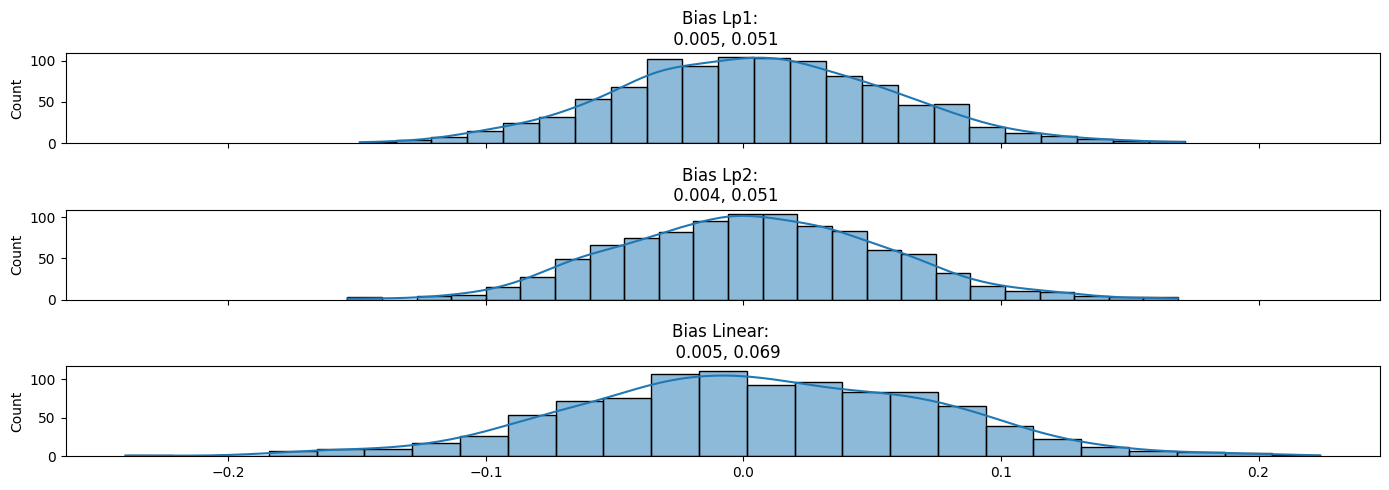

In [8]:
f, ax = plt.subplots(3, 1, figsize=(14, 5), sharex=True)
sns.histplot(biases_reg_1, ax=ax[0], kde=True)
ax[0].set_title(
    f"Bias Lp1: \n {biases_reg_1.mean():.3f}, {biases_reg_1.std():.3f}"
)
sns.histplot(biases_reg_2, ax=ax[1], kde=True)
ax[1].set_title(
    f"Bias Lp2: \n {biases_reg_2.mean():.3f}, {biases_reg_2.std():.3f}"
)
sns.histplot(biases_ols, ax=ax[2], kde=True)
ax[2].set_title(f"Bias Linear: \n  {biases_ols.mean():.3f}, {biases_ols.std():.3f}")
# sns.histplot(biases_simplex, ax=ax[3], kde=True)
# ax[3].set_title(
#     f"Bias Simplex: \n  {biases_simplex.mean():.3f}, {biases_simplex.std():.3f}"
# )
f.tight_layout()